In [1]:
# Import libraries -

# Visualization
import shap
%matplotlib inline
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11,9)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')
import eli5
from eli5.sklearn import PermutationImportance
from datetime import timedelta, datetime

# Data Wrangling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)

# Model Creation
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('GTWYElec.csv')

df.head()

,Date,0:30,1:00,1:30,2:00,2:30,3:00,3:30,4:00,4:30,5:00,5:30,6:00,6:30,7:00,7:30,8:00,8:30,9:00,9:30,10:00,10:30,11:00,11:30,12:00,12:30,13:00,13:30,14:00,14:30,15:00,15:30,16:00,16:30,17:00,17:30,18:00,18:30,19:00,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,24:00:00
0,5/7/2008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,35.890,40.259,40.112,39.239,38.371,38.480,41.237,51.083,45.937,44.521,31.485,29.263,26.422,20.617,27.207,14.582,16.216,14.448,12.958,11.891,12.999,11.803,12.124,11.363,11.440,10.113
1,5/8/2008,11.593,11.033,11.285,14.218,10.644,11.374,11.047,11.375,11.461,13.766,12.622,18.129,17.433,19.016,25.426,32.918,43.044,47.953,47.473,48.607,44.115,51.469,50.738,45.899,44.794,46.398,42.846,53.267,49.682,48.661,46.623,48.091,38.152,28.436,21.252,21.096,19.803,16.227,15.713,14.839,11.117,11.433,11.780,11.663,11.569,12.250,13.390,14.202
2,5/9/2008,12.168,11.206,10.073,10.997,14.464,11.528,12.849,11.070,15.063,14.445,13.877,14.198,15.805,22.208,26.209,31.485,37.986,42.763,47.323,46.988,46.473,50.580,47.865,45.864,47.414,47.260,48.767,49.047,47.026,47.962,41.071,41.959,28.616,24.792,18.129,19.459,18.876,17.078,16.326,14.226,9.921,10.723,10.493,10.418,10.209,10.498,10.469,9.168
3,5/10/2008,10.383,10.415,10.602,10.293,10.283,10.958,10.753,10.824,10.479,10.318,9.711,11.209,10.395,10.574,11.587,13.125,13.028,14.212,12.827,14.716,12.811,11.202,10.397,12.751,12.510,9.005,10.399,11.153,10.473,10.503,12.184,10.924,10.739,9.546,11.140,11.074,13.442,11.720,10.468,11.864,10.572,11.757,10.873,9.828,10.056,14.093,9.173,13.779
4,5/11/2008,11.721,8.893,9.132,10.808,11.878,11.038,10.061,11.020,10.506,10.556,12.622,10.845,11.796,11.648,11.865,10.479,12.809,12.413,12.526,10.889,13.910,10.870,12.380,12.716,11.196,11.670,12.020,10.772,11.657,12.200,13.063,15.216,11.261,11.528,11.903,12.205,11.719,11.820,11.257,10.710,11.501,10.380,11.260,12.373,10.939,12.363,12.938,10.654


In [3]:
GTWYElec = pd.melt(df, id_vars=["Date"], var_name='time')
GTWYElec['time'] = pd.to_timedelta(GTWYElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
GTWYElec['Date'] = pd.to_datetime(GTWYElec['Date'], format="%m/%d/%Y")
GTWYElec['Datetime'] = GTWYElec['Date'] + GTWYElec['time']
GTWYElec = GTWYElec.set_index('Datetime')
GTWYElec = GTWYElec.drop(['Date', 'time'], axis=1).sort_index()

In [4]:
# View formatted data
GTWYElec.head(100)

,value
Datetime,
2008-05-07 00:00:00,0.000
2008-05-07 00:30:00,0.000
2008-05-07 01:00:00,0.000
2008-05-07 01:30:00,0.000
2008-05-07 02:00:00,0.000
...,...
2008-05-08 23:30:00,14.202
2008-05-09 00:00:00,12.168
2008-05-09 00:30:00,11.206


In [5]:
def preprocess_data(df):
    df.sort_index()
    df = df.groupby(df.index).first()

    df = df.asfreq('H')

    return df

data = preprocess_data(GTWYElec)

data.index

DatetimeIndex(['2008-05-07 00:00:00', '2008-05-07 01:00:00',
               '2008-05-07 02:00:00', '2008-05-07 03:00:00',
               '2008-05-07 04:00:00', '2008-05-07 05:00:00',
               '2008-05-07 06:00:00', '2008-05-07 07:00:00',
               '2008-05-07 08:00:00', '2008-05-07 09:00:00',
               ...
               '2022-02-28 14:00:00', '2022-02-28 15:00:00',
               '2022-02-28 16:00:00', '2022-02-28 17:00:00',
               '2022-02-28 18:00:00', '2022-02-28 19:00:00',
               '2022-02-28 20:00:00', '2022-02-28 21:00:00',
               '2022-02-28 22:00:00', '2022-02-28 23:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121104, freq='H')

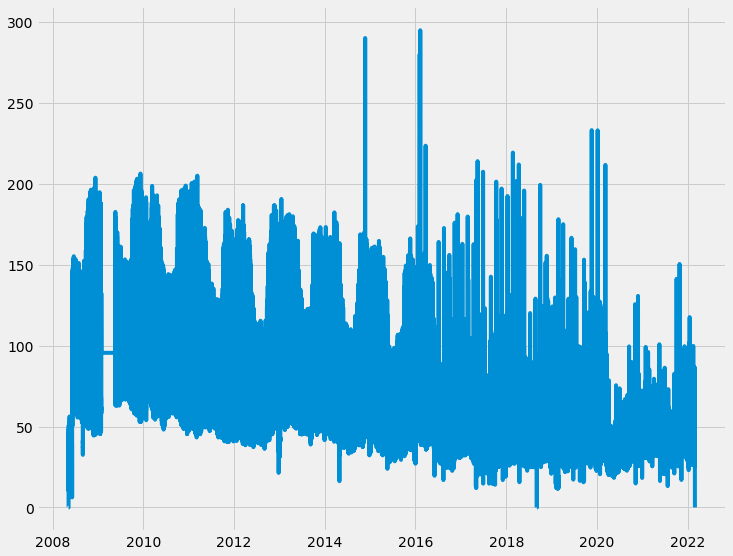

In [6]:
plt.plot(data)

In [7]:
daily_data = data.resample(rule="D").sum()

daily_data = daily_data.asfreq('D')

daily_data.head(10)

,value
Datetime,
2008-05-07,352.398
2008-05-08,623.602
2008-05-09,607.472
2008-05-10,265.285
2008-05-11,281.920
2008-05-12,544.550
2008-05-13,580.021
2008-05-14,591.166
2008-05-15,654.893


<AxesSubplot:xlabel='Datetime'>

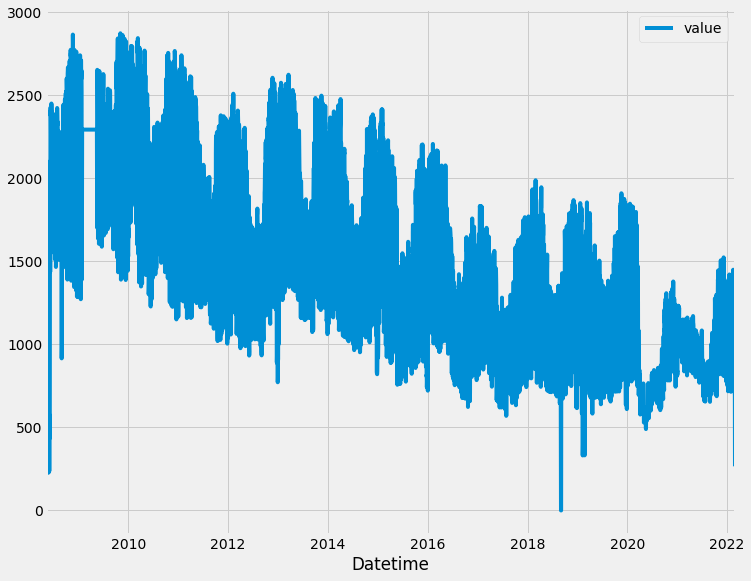

In [8]:
daily_data.plot()

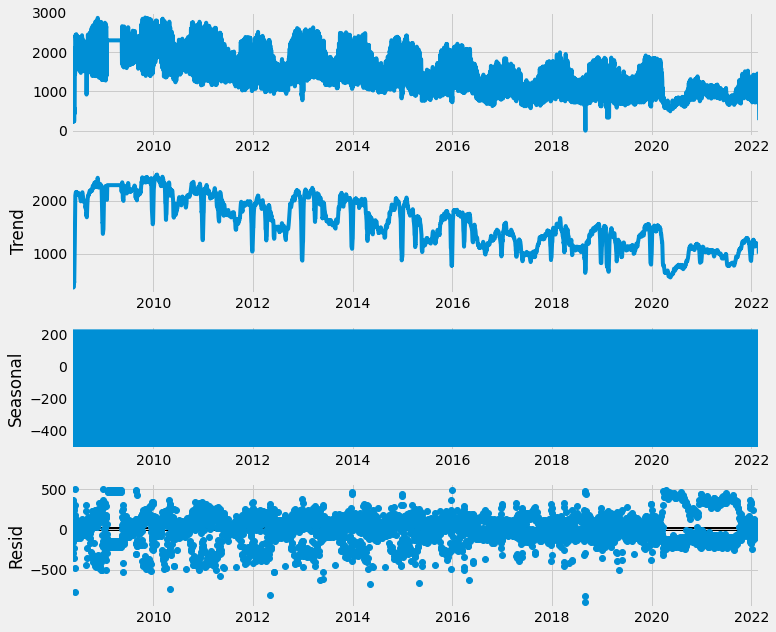

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_data, model='additive')

fig = decomposition.plot()

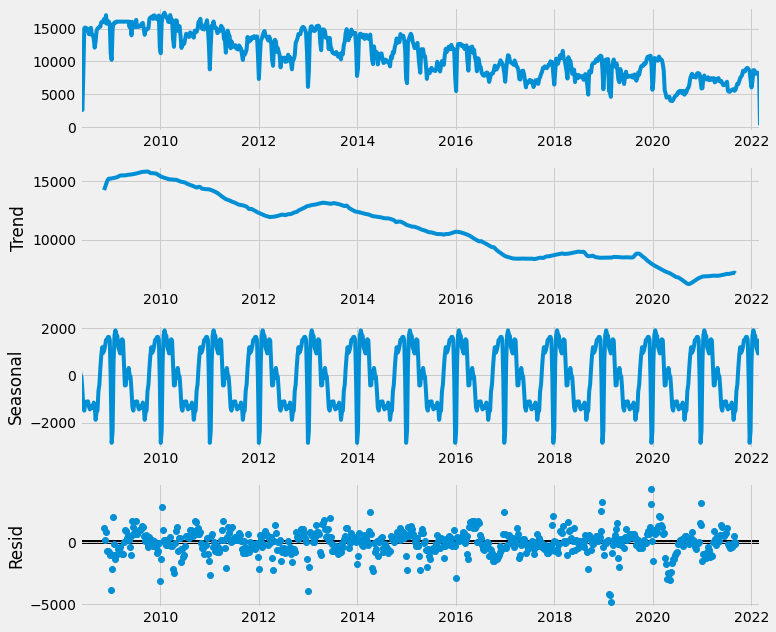

In [10]:
weekly_data = data.resample(rule='W').sum()
decomposition = seasonal_decompose(weekly_data, model='additive')

fig = decomposition.plot()

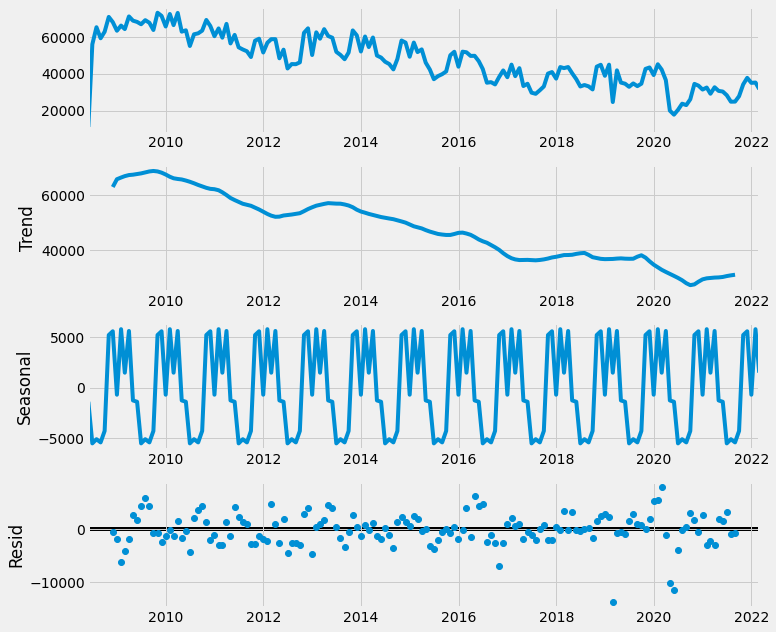

In [11]:
monthly_data = data.resample(rule='M').sum()
decomposition = seasonal_decompose(monthly_data, model='additive')

fig = decomposition.plot()

In [12]:
daily_data.index.day_name()

Index(['Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       ...
       'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Monday'],
      dtype='object', name='Datetime', length=5046)

In [13]:
#Create new dataset for heatmap
heatmap_data = daily_data.copy()

#First we need to add weekdays as a column
heatmap_data['Weekday_Name'] = daily_data.index.day_name()

#Next add the year as column and group the data up to annual day of the week level
heatmap_data['Year'] = heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday_Name']).sum()

#Reset indices
heatmap_data = heatmap_data.reset_index()

# Drop 2022 as not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2022]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday_Name', values='value')

# Reorder columns
heatmap_data = heatmap_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

heatmap_data.head(100)

Weekday_Name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Year,,,,,,,
2008,73435.284,73848.023,73326.501,73385.281,71033.847,45329.692,46254.184
2009,125343.080,125744.340,125751.228,127611.020,122545.658,95144.163,93871.246
2010,122127.931,124499.544,124573.301,125487.505,121064.513,78773.601,79039.438
2011,110123.691,113082.361,111932.624,112393.895,106790.690,67047.414,64683.126
2012,101304.137,104121.877,104382.353,102846.346,100093.866,59868.360,59689.160
2013,108654.910,110371.015,110294.037,111505.084,107919.062,67848.219,67049.295
2014,98124.034,101166.924,101465.790,102137.050,98427.010,59817.816,58203.094
2015,90465.807,92408.503,91238.292,92311.714,86100.663,50917.900,49272.108
2016,81957.336,85353.461,85149.801,85047.709,81929.121,49367.630,46611.752


Text(0.5, 1.0, 'Heatmap - by Day of Week')

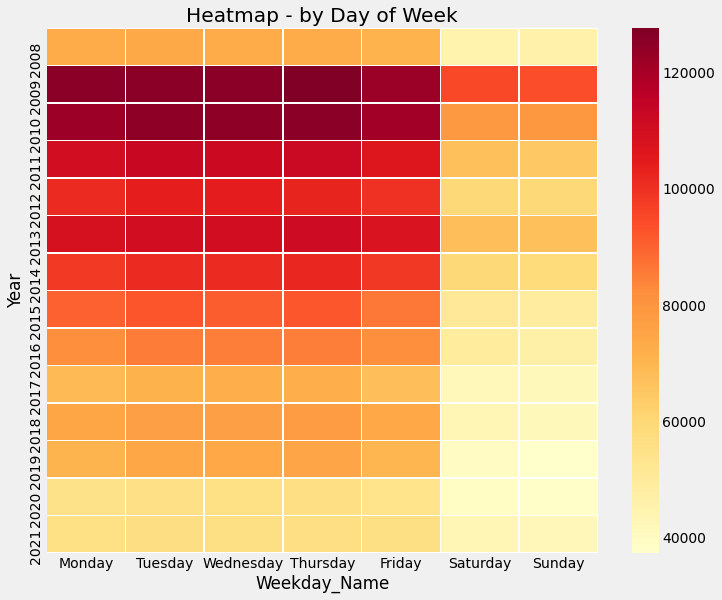

In [14]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True).set_title('Heatmap - by Day of Week')

In [15]:
heatmap_data = data.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = data.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).sum()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We drop off 2018 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2022]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='value')

heatmap_data.head(100)

Hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Year,,,,,,,,,,,,,,,,,,,,,,,,
2008,12573.696,12532.598,12560.105,12526.978,12490.705,12963.045,14670.494,19349.788,24485.335,26777.404,27491.179,27561.004,27214.256,27305.590,27409.504,26713.895,24210.077,20969.112,18070.428,16072.699,14318.272,12975.892,12712.658,12658.098
2009,27527.537,27433.259,27405.666,27374.951,27318.809,27816.547,29740.681,34280.068,39182.033,42077.328,42870.742,43039.652,42739.153,42683.442,42762.034,42011.271,39215.169,35527.341,32544.433,30389.008,28948.249,27911.134,27622.615,27589.613
2010,22988.962,22918.559,22938.523,22933.585,22863.461,23952.237,26681.621,32710.650,39661.269,43982.556,44948.581,45196.709,44834.137,44971.510,45148.628,44084.406,39986.716,34242.885,29916.628,26658.739,24731.644,23325.032,22922.260,22966.535
2011,18807.623,18664.379,18666.606,18586.701,18556.306,19661.871,22392.651,28695.674,36359.568,40895.623,42152.854,42450.621,41843.651,41822.476,42143.650,41308.693,36704.204,30379.455,25670.313,22463.282,20646.755,19414.957,18924.530,18841.358
2012,17283.075,17167.915,17181.537,17083.720,17062.861,18328.644,20939.595,26999.023,33921.599,37411.067,38735.152,39099.213,38611.375,38669.676,38923.859,38107.478,33607.544,27722.260,23510.715,20515.541,18863.537,17863.989,17355.415,17341.309
2013,19683.358,19715.941,19565.322,19382.914,19357.780,20715.499,23670.572,29313.039,34966.606,39244.381,40593.725,40852.510,40475.203,40349.464,40500.985,39509.792,35212.150,30363.662,26227.000,23246.381,21338.770,20100.634,19657.391,19598.543
2014,17707.343,17842.176,17791.024,17615.799,17603.870,17920.228,19726.419,23794.728,29036.131,33903.845,35838.590,36397.792,36305.734,36207.755,36537.430,36751.264,34873.909,30104.109,25782.958,22657.061,20297.797,18883.293,18002.046,17760.417
2015,15109.612,15141.872,15079.279,14972.793,15054.263,16223.077,18545.736,22844.736,28277.308,32488.288,33340.319,33426.324,32938.954,32899.938,33489.483,33545.188,30343.270,25196.008,21611.448,18967.209,17234.153,15831.268,15122.640,15031.821
2016,14484.630,14424.521,14304.636,14165.471,14352.121,15003.096,16754.356,20590.838,25467.305,29241.220,30127.650,30431.090,30486.390,29920.893,30249.041,30401.525,28748.122,24601.370,21227.496,18928.656,16884.025,15417.220,14704.478,14500.660


Text(0.5, 1.0, 'Heatmap - by Hour of the day')

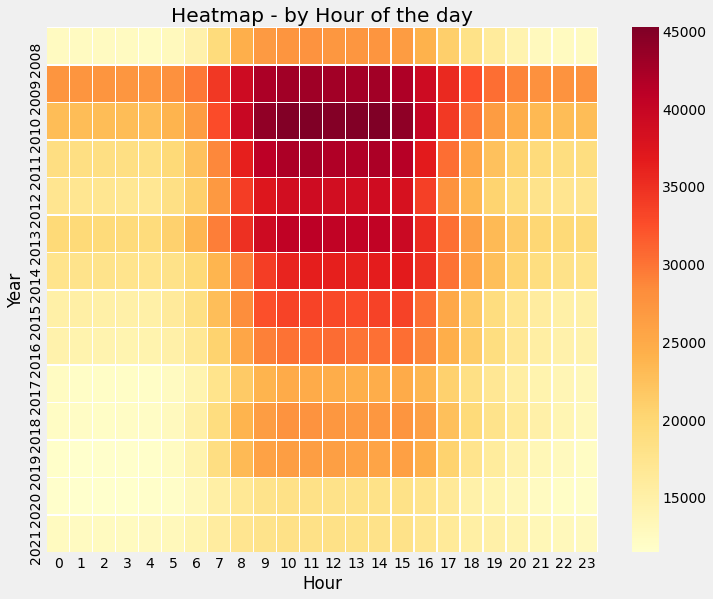

In [16]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True).set_title('Heatmap - by Hour of the day')

In [17]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Month'] = daily_data.index.month_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).sum()

# Reset index
heatmap_data = heatmap_data.reset_index()

# We drop off 2022 because it's not a full year
heatmap_data = heatmap_data[heatmap_data['Year'] != 2022]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='value')

# Reorder columns
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

heatmap_data.head(10)

Month,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2008,NaN,NaN,NaN,NaN,11115.184,55979.370,65254.720,59263.317,62789.555,70841.382,68027.350,63341.934
2009,66134.684,64238.496,71121.192,68826.960,68134.592,66868.075,69086.667,67666.562,63751.893,73110.531,71419.949,65651.134
2010,72438.564,66396.943,73020.517,62845.368,63571.697,55063.676,61412.838,61939.059,63396.077,69185.920,65915.767,60379.407
2011,64596.745,59572.102,67062.869,56450.261,61078.445,54342.973,53167.822,52192.830,49079.510,57951.813,59022.281,51536.150
2012,56835.677,58759.667,58775.103,48377.004,53063.061,42857.497,45242.300,45177.594,46186.453,62218.793,64641.015,50171.935
2013,62480.894,59032.093,64195.912,60485.594,59552.558,51890.450,50193.252,47880.819,51515.106,63510.496,60836.770,52067.678
2014,60211.605,54485.786,59663.301,49869.736,48778.355,46524.311,45263.804,42368.382,48000.285,58041.363,56911.260,49223.530
2015,56926.935,51754.645,53220.995,46034.139,42257.143,37028.140,38706.244,39759.936,41245.881,50026.931,51932.292,43821.706
2016,51980.049,51641.420,49675.640,49735.215,46824.198,42570.868,35130.660,35426.515,34202.445,38313.575,41796.464,38119.761


Text(0.5, 1.0, 'Heatmap - by Months of the Year')

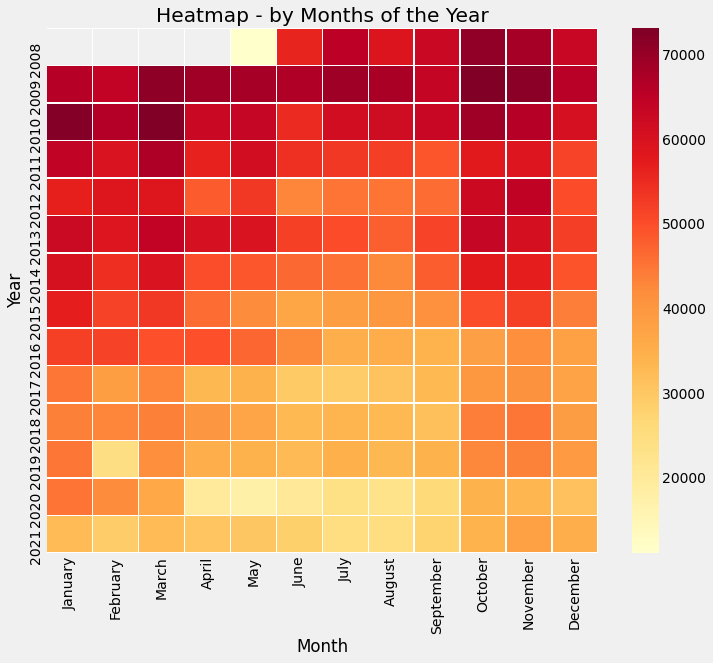

In [18]:
# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True).set_title('Heatmap - by Months of the Year')

# Train Test Split

In [23]:
# target = 'value'

# # Split data into x and y
# x = daily_data.drop(columns=target)
# y = daily_data[target]

# # split data into train / validation sets
# X_train,X_val,y_train,y_val = train_test_split(x,y,test_size=.2,random_state=42)

## Baselines

In [26]:
# # Assign variables for baselines and calculate baselines
# y_pred = [y_train.mean()]*len(y_train)
# mean_baseline_pred = y_train.mean()
# baseline_mae = mean_absolute_error(y_train,y_pred)
# baseline_rmse = mean_squared_error(y_train,y_pred,squared=False)

# # Print statement to show all baseline values
# print('Mean Price Per KW/h Baseline Pred:', mean_baseline_pred)
# print('-------------------------------------------------------------------')
# print('Baseline Mae:',baseline_mae)
# print('-------------------------------------------------------------------')
# print('Baseline RMSE:',baseline_rmse)

Mean Price Per KW/h Baseline Pred: 1552.135843904856
-------------------------------------------------------------------
Baseline Mae: 499.91734781613644
-------------------------------------------------------------------
Baseline RMSE: 589.3900605785752


In [27]:
df_resample = data.resample('h').mean()

df_resample.shape

(121104, 1)

In [28]:
df_resample.head()

,value
Datetime,
2008-05-07 00:00:00,0.0
2008-05-07 01:00:00,0.0
2008-05-07 02:00:00,0.0
2008-05-07 03:00:00,0.0
2008-05-07 04:00:00,0.0


<AxesSubplot:xlabel='Datetime'>

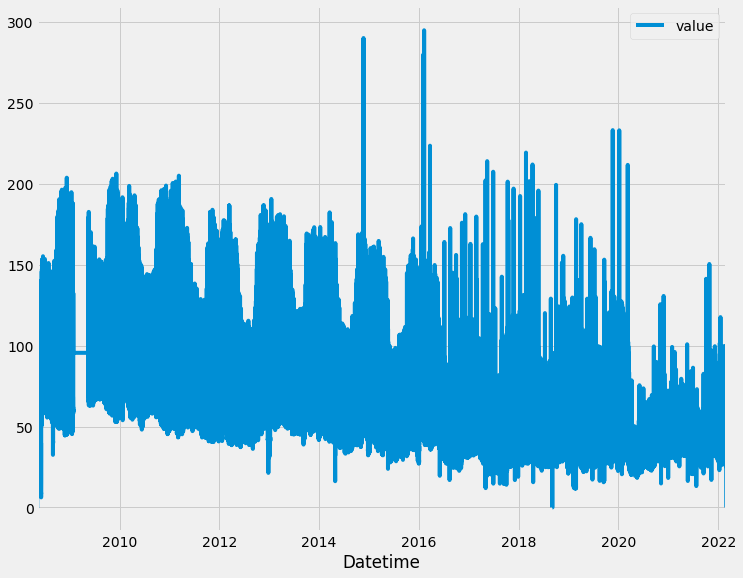

In [29]:
df_resample.plot()

In [39]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []

    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [40]:
window_size = 5
X, y = df_to_X_y(df_resample, window_size)
X.shape, y.shape

((121099, 5, 1), (121099, 1))

In [41]:
X_train, y_train = X[:110000], y[:110000]
X_val, y_val = X[110000:115000], y[110000:115000]
X_test, y_test = X[115000:], y[115000:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((110000, 5, 1), (110000, 1), (5000, 5, 1), (5000, 1), (6099, 5, 1), (6099, 1))

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [43]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [44]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
3438/3438 [==============================] - 15s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/10
3438/3438 [==============================] - 13s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/10
3438/3438 [==============================] - 14s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/10
3438/3438 [==============================] - 14s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/10
3438/3438 [==============================] - 14s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/10
3438/3438 [==============================] - 13s 4ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 7/10
3438/3438 [

In [46]:
from tensorflow.keras.models import load_model
model = load_model('model/')

OSError: SavedModel file does not exist at: model/\{saved_model.pbtxt|saved_model.pb}

In [47]:
train_pred = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_pred, 'Actuals': y_train})
train_results

Exception: Data must be 1-dimensional